# Mounting Google Drive

In [1]:
save_images = False
gen_simple_stable_diff_image = True

In [2]:
if save_images:
  from google.colab import drive
  drive.mount('/content/drive')
  from google.colab import files

# Install dependencies for Stable / Dense Diffusion and Detectron2



In [3]:
install_dependencies = True

if install_dependencies:

  # Dense Diffusion Libraries
  !pip -q uninstall -y jax jaxlib flax
  !pip -q install jax==0.4.19 jaxlib==0.4.19 flax==0.8.3
  !pip -q install diffusers==0.20.2 transformers==4.28.0 gradio==3.43.2 accelerate
  !pip -q install torch numpy tqdm Pillow torchvision
  !pip -q show jax jaxlib

  # Our Libraries
  !pip -q install cython pyyaml==5.1
  !pip -q install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
  !pip -q install -U 'git+https://github.com/facebookresearch/fvcore.git'
  !git clone https://github.com/facebookresearch/detectron2.git
  !pip -q install -e detectron2
  !pip -q install openai

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6 requires pycocotools>=2.0.2, but you have pycocotools 2.0 which is incompatible.
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

# **Importing Libraries**

In [4]:
from detectron2 import model_zoo
import re
import torch
from diffusers import StableDiffusionPipeline, DiffusionPipeline, DDIMScheduler
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
import numpy as np
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import ColorMode, Visualizer
from openai import OpenAI
import ast
from google.colab import userdata
import json

# Specific Dense Diffusion Libraries
import random
import pickle
from tqdm.auto import tqdm
import transformers
from transformers import CLIPTextModel, CLIPTokenizer
import torch.nn.functional as F
from torchvision import transforms
import diffusers

# **GPT 4o Mini**

In [5]:
def gpt_4o_mini(prompt,instruction):
  messages=[
      {"role": "system", "content": instruction},
    ]
  client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

  messages.append({"role":"user","content":prompt})
  try:
    completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
    )
    response = completion.choices[0].message.content
  except Exception as e:
      print(f"An error occurred: {e}")
      response = ""

  return response


# **Object Identifier**

In [6]:
def getobjects(user_input):
  instruction = "Extract simple and drawable objects from the prompt. Avoid backgrounds/setting/place. The prompt will have the following format, \"Prompt: \"A cat sitting on a mat.\" Return in the objects in a list like as follows \"Cat\", \"Mat\""
  gpt_4o_mini_response = gpt_4o_mini(user_input, instruction)

  try:
    # Try to parse with ast.literal_eval
    identified_objects = ast.literal_eval(gpt_4o_mini_response)
  except (ValueError, SyntaxError):
    try:
        # Fallback to JSON parsing
        identified_objects = json.loads(gpt_4o_mini_response)
    except json.JSONDecodeError as e:
        try:
          identified_objects = gpt_4o_mini_response.split(", ")
        except Exception as e:
          print("gpt_4o_mini_response =",gpt_4o_mini_response)
          print(f"An error occurred while parsing the response: {e}")
          identified_objects = []

  return identified_objects


# **Prompt Generator**

In [7]:
def get_edited_prompts(user_input,identified_object):

    instruction = f"""You are given a prompt and an object.
    The prompt describes a scene in which multiple objects are interacting with each other.
    The object you are provided with is one of the objects in the prompt.
    You are to make a simpler prompt from the original one that focuses more on given object and not at the other objects in the original prompt.
    Give a very simple prompt. keep the simpler prompt short"""

    prompt = f"""Prompt: {user_input}
            object: {identified_object}"""

    gpt_4o_mini_response = gpt_4o_mini(prompt,instruction)
    edited_prompt = gpt_4o_mini_response
    return edited_prompt.strip()

# **Making Object & Editied Prompts arraies**

In [8]:
# Arrays to store objects and edited prompts
objects_array = []
edited_prompts_array = []

# Test with multiple prompts
prompts = [
    # "A cat sitting next to a bus.",
    # "A dog chasing a butterfly in a meadow.",
    # "A child holding a red balloon in a park.",
    # "A chef preparing sushi in a kitchen.",
    "A bird perched on a windowsill with a view of the city skyline.",
    # "A woman reading a book under a large oak tree.",
    # "A robot serving coffee in a cozy café.",
    # "A man playing the violin on a quiet beach at sunset.",
    # "A pair of glasses resting on a stack of books.",
    # "A horse grazing in a field with a mountain in the background.",
    # "A giraffe drinking water next to a small pond.",
    # "A dog sitting beside a zebra, both looking in different directions.",
    # "A boat floating on a calm lake with a forest in the distance.",
    # "A bicycle leaning against a lamppost in a quiet street.",
    # "A painter working on a canvas with a cityscape in the background.",
    # "A picnic setup with a basket, blanket, and fruit on a sunny day.",
    # "A skateboard leaning against a graffiti-covered wall.",
    # "A piano in a large, empty concert hall.",
    # "A lighthouse standing tall on a rocky cliff by the ocean.",
    # "A telescope pointing towards the night sky filled with stars."
]

recusive_diff_prompt = prompts[0]

# Step 1: Identify objects in the recusive_diff_prompt
identified_objects = getobjects(recusive_diff_prompt)

if isinstance(identified_objects, str):
  identified_objects = [identified_objects]

print("identified_objects =",identified_objects)

# Step 2: Generate edited recusive_diff_prompts for each identified object
for obj in identified_objects:
    print("===================================")
    # check
    if(obj.lower() not in recusive_diff_prompt.lower()):
      print(f"Object '{obj}' not found in the recusive_diff_prompt. Skipping...")
      continue

    edited_prompt = get_edited_prompts(recusive_diff_prompt, obj)

    # checking if obj in editied prompt
    if(obj.lower() not in edited_prompt.lower()):
      print(f"Object = '{obj}' not found in the edited prompt. edited_prompt = {edited_prompt} Skipping...")
      continue

    # Store in arrays
    objects_array.append(obj)
    edited_prompts_array.append(edited_prompt)

    print(f"recusive_diff_prompt: {recusive_diff_prompt}")
    print(f"Identified Object: {obj}")
    print(f"Edited Prompt: {edited_prompt}")

# Print arrays to verify
print("===================================")
print("Objects Array:", objects_array)
print("Edited Prompts Array:", edited_prompts_array)

identified_objects = ('Bird', 'Windowsill')
recusive_diff_prompt: A bird perched on a windowsill with a view of the city skyline.
Identified Object: Bird
Edited Prompt: A bird sits on a windowsill.
recusive_diff_prompt: A bird perched on a windowsill with a view of the city skyline.
Identified Object: Windowsill
Edited Prompt: A windowsill with a bird on it.
Objects Array: ['Bird', 'Windowsill']
Edited Prompts Array: ['A bird sits on a windowsill.', 'A windowsill with a bird on it.']


# Image Generation using Stable Diffusion based on the Entities Array Given

### Authenticate with Hugging Face Hub using your API token


In [9]:
device = "cuda:0"

if save_images:
  output_dir = "/content/drive/My Drive/Colab Notebooks/Dense Diffusion/GeneratedImages/"
  # Ensure the output directory exists
  os.makedirs(output_dir, exist_ok=True)

In [10]:
# Example entities
entities = edited_prompts_array

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Setup complete. Token and device initialized.
Generating simple stable diffusion image


  0%|          | 0/50 [00:00<?, ?it/s]

Processing entity 1/2: A bird sits on a windowsill.


  0%|          | 0/50 [00:00<?, ?it/s]

Processing entity 2/2: A windowsill with a bird on it.


  0%|          | 0/50 [00:00<?, ?it/s]

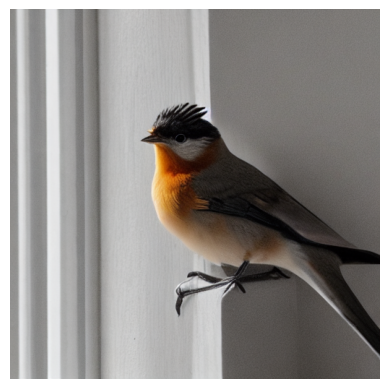

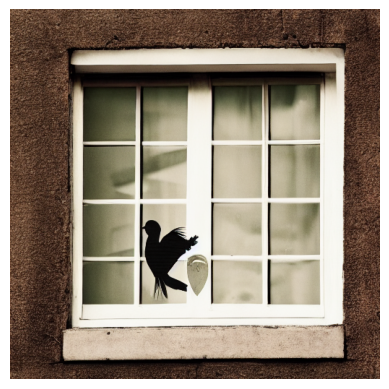

In [11]:
# Load the Stable Diffusion 1.5 model with specified scheduler and configuration
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    variant="fp16",
    cache_dir='./models/diffusers/',
    use_auth_token=userdata.get("HF_TOKEN")
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps
sp_sz = pipe.unet.sample_size
bsz = 1

print("Setup complete. Token and device initialized.")

# Function to generate image from prompt using the loaded pipeline
def generate_image(prompt):
    image = pipe(prompt).images[0]
    return image

images = []

# Making Image for simple Stable Diffusion
if gen_simple_stable_diff_image:
  print("Generating simple stable diffusion image")
  stable_diffusion_image = generate_image(recusive_diff_prompt)

for idx, entity in enumerate(edited_prompts_array):
    print(f"Processing entity {idx + 1}/{len(edited_prompts_array)}: {entity}")
    image = generate_image(entity)
    images.append(image)
    # Save the generated image
    if save_images:
      image.save(f"{output_dir}{entity.replace(' ', '_')}_{idx}.jpg")

# Display generated images
for idx, image in enumerate(images):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Extracting the required Entities Segments from the Generated Images

In [12]:
# Setup configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5

# Create predictor
predictor = DefaultPredictor(cfg)

model_final_c10459.pkl: 184MB [00:01, 181MB/s]                           


In [13]:
def random_color(used_colors):
    while True:
        color = tuple(np.random.randint(0, 255, size=3, dtype=np.uint8))
        if color not in used_colors:
            used_colors.add(color)
            return color

def segment_entity(image, target_class_name):
    used_colors = set()

    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Perform panoptic segmentation
    outputs = predictor(image)
    panoptic_seg, segments_info = outputs["panoptic_seg"]

    # Display the panoptic segmentation results
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    cv2_imshow(out.get_image()[:, :, ::-1])

    # Extract and visualize the specific segment by its class name
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    category_id = None

    if target_class_name in metadata.thing_classes:
        category_id = metadata.thing_classes.index(target_class_name)
    elif target_class_name in metadata.stuff_classes:
        category_id = metadata.stuff_classes.index(target_class_name) + len(metadata.thing_classes)

    if category_id is not None:
        # Create a mask for the target segment
        mask = torch.zeros_like(panoptic_seg, dtype=torch.uint8)
        segment_found = False
        for segment in segments_info:
            if segment["category_id"] == category_id:
                mask[panoptic_seg == segment["id"]] = 255
                segment_found = True

        # If the segment is found, extract it
        if segment_found:
            mask = mask.cpu().numpy().astype(bool)

            # Create an image with transparency
            extracted_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

            # Apply the mask to the original image with a unique color
            color = random_color(used_colors)
            extracted_image[mask] = [color[2], color[1], color[0], 255]

            # Convert to RGBA format
            extracted_image = cv2.cvtColor(extracted_image, cv2.COLOR_BGRA2RGBA)

            extracted_pil_image = Image.fromarray(extracted_image)
            # Save the extracted image
            if save_images:
              extracted_pil_image.save(f"{output_dir}extracted_{target_class_name}.png")

            return extracted_pil_image
        else:
            print("Segment not found")
            return None
    else:
        print("Target class not in metadata")
        print("Thing Classes:", metadata.thing_classes)
        print("Stuff Classes:", metadata.stuff_classes)
        return None

# **Changing Object Names to work with Detectron2**

In [14]:
print("Original objects:", objects_array)
entities = [items.lower() for items in objects_array]

# Update the entities array directly
for index in range(len(entities)):
    if entities[index].lower() == 'ball':
        entities[index] = 'sports ball'
    if entities[index] == 'balloon':
        entities[index] = 'frisbee'
    if entities[index] == 'chef':
        entities[index] = 'person'
    if entities[index] == 'child':
        entities[index] = 'person'
    if entities[index].lower() == 'oak tree':
        entities[index] = 'tree'
    if entities[index].lower() == 'lion':
        entities[index] = 'dog'
    if entities[index].lower() == 'cliff':
        entities[index] = 'rock'
    if entities[index].lower() == 'lighthouse':
        entities[index] = 'building'
    if entities[index].lower() == 'windowsill':
        entities[index] = 'window'

print("Updated entities:", entities)


Original objects: ['Bird', 'Windowsill']
Updated entities: ['bird', 'window']


# **Extracting Images**

entity = bird


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


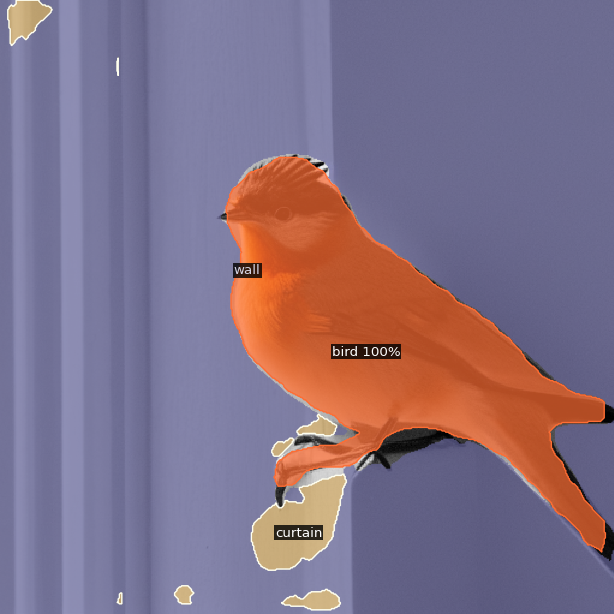

entity = window


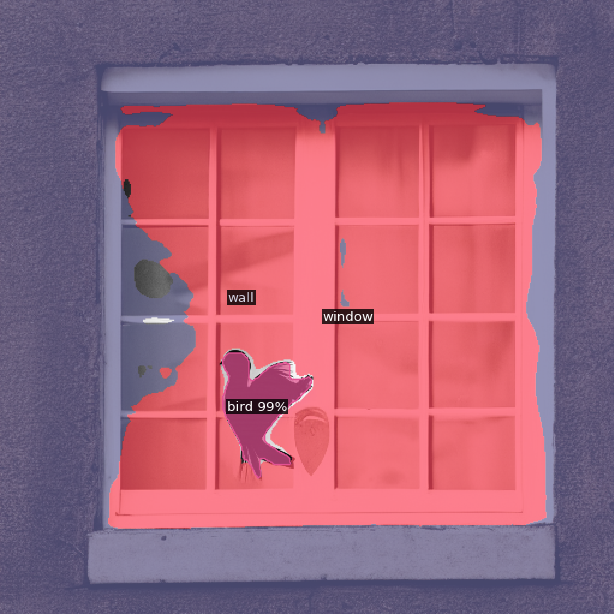

Segment not found


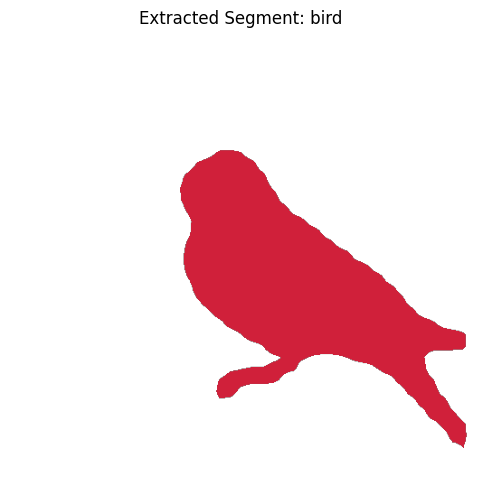

In [15]:
extracted_images = {}

# Iterate through images and entity array
for i, (image, entity) in enumerate(zip(images, entities)):
    entity = entities[i]
    print("entity =", entity)
    extracted_images[entity] = segment_entity(image, entity)

# Display the extracted images
for entity, extracted_image in extracted_images.items():
  if extracted_image is not None:
    plt.figure(figsize=(12, 6))
    plt.imshow(extracted_image)
    plt.axis('off')
    plt.title(f'Extracted Segment: {entity}')
    plt.show()

In [16]:
print("old extracted_images")
print(extracted_images)
print("objects_array =",objects_array)

extracted_images_copy = {}
objects_array_copy = objects_array.copy()
objects_array=[]

for index in entities:
  print("index =",index)
  objects_array_copy.reverse()
  curr_obj = objects_array_copy.pop()
  objects_array_copy.reverse()
  print("curr_obj =",curr_obj)
  if(extracted_images[index] != None):
    extracted_images_copy[index] = extracted_images[index]
    objects_array.append(curr_obj)

extracted_images = extracted_images_copy

print("new extracted_images")
print(extracted_images)
print("objects_array =",objects_array)

old extracted_images
{'bird': <PIL.Image.Image image mode=RGBA size=512x512 at 0x7D1C2AFF4850>, 'window': None}
objects_array = ['Bird', 'Windowsill']
index = bird
curr_obj = Bird
index = window
curr_obj = Windowsill
new extracted_images
{'bird': <PIL.Image.Image image mode=RGBA size=512x512 at 0x7D1C2AFF4850>}
objects_array = ['Bird']


# Stacking the Extracted Segments based on the given Array of the Order

In [17]:
def get_grid_positions_and_stack(prompt, objects_array):
    # Create the prompt
    instruction = f"""
    You are given a 3x3 grid with 9 boxes. The grid has the following format:
    1 2 3
    4 5 6
    7 8 9
    You are also provided with a prompt and a list of extracted objects. For each object, determine which box(es) it should occupy in the grid. If the object occupies multiple boxes, list all the boxes it occupies. Additionally, determine the stacking order of the objects, meaning which objects should appear on top of others.

    Consider the objects' relationship in the prompt and suggest the most visually appealing and logically correct arrangement.

    Return the result in a valid JSON format as follows:
    {{
        "grid_positions": {{
            "Object Name 1": [list_of_boxes],
            "Object Name 2": [list_of_boxes]
        }},
        "stacking_order": ["Object Name 1", "Object Name 2"]
    }}
    Make sure the JSON is correctly formatted.
    """

    prompt_content = f"Prompt: {prompt}\nObjects: {objects_array}"

    gpt_4o_mini_response = gpt_4o_mini(prompt_content,instruction)

    # Remove triple backticks and any extra whitespace
    cleaned_response = gpt_4o_mini_response.strip("```").strip()

    # Check for prefix issues like "json\n{...}"
    if cleaned_response.startswith("json"):
      cleaned_response = cleaned_response[len("json"):].strip()

    # Remove any comments in the response
    cleaned_response = '\n'.join(line for line in cleaned_response.splitlines() if not line.strip().startswith("//"))

    print("cleaned_response =",cleaned_response)

    try:
        gpt_4o_mini_response = json.loads(cleaned_response)
        grid_positions_by_gpt = gpt_4o_mini_response["grid_positions"]
        stacking_order_by_gpt = gpt_4o_mini_response["stacking_order"]

        print("gpt_4o_mini_response =",gpt_4o_mini_response)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", str(e))
        grid_positions_by_gpt = None
        stacking_order_by_gpt = None

    return grid_positions_by_gpt, stacking_order_by_gpt

grid_positions,stacking_order = get_grid_positions_and_stack(recusive_diff_prompt, objects_array)
print("Grid Positions =",grid_positions)
print("Stacking Order =",stacking_order)

cleaned_response = {
    "grid_positions": {
        "Bird": [3]
    },
    "stacking_order": ["Bird"]
}
gpt_4o_mini_response = {'grid_positions': {'Bird': [3]}, 'stacking_order': ['Bird']}
Grid Positions = {'Bird': [3]}
Stacking Order = ['Bird']


In [18]:
#Specify the order
default_order_of_images = list(extracted_images.keys())
print("default_order_of_images =",default_order_of_images)
print("stacking_order =",stacking_order)
order = []
for image in stacking_order:
  i = 1
  for curr_image in objects_array:
    if(image.lower() == curr_image.lower()):
      order.append(i)
      break
    i += 1

order.reverse()
print("order =",order)

default_order_of_images = ['bird']
stacking_order = ['Bird']
order = [1]


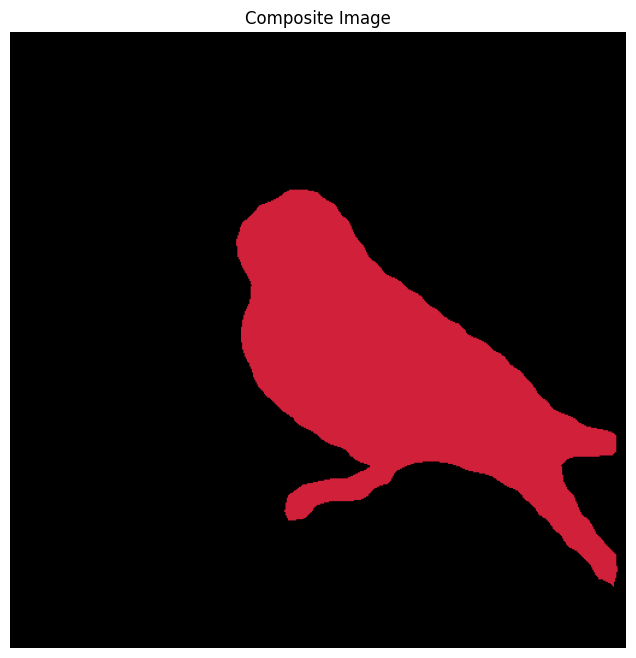

Composite image saved as: None


In [19]:
# Global variable for filename
filename = None
layout_img_path = None

def get_next_filename(output_dir):
    global filename  # Declare the global variable

    # List all files in the directory
    files = os.listdir(output_dir)

    # Filter for files with a numeric name and get the highest number
    numbers = [int(f.split('.')[0]) for f in files if f.endswith('.png') and f.split('.')[0].isdigit()]

    # Determine the next number
    next_number = max(numbers, default=-1) + 1

    # Update the global filename
    filename = f"{next_number}.png"
    return filename

def overlay_images(images_dict, order, output_dir):
    # Get the size of the images
    image_shape = next(iter(images_dict.values())).size  # Assuming all images are of the same size
    width, height = image_shape

    # Create a blank canvas with a black background
    canvas = Image.new('RGBA', (width, height), (0, 0, 0, 255))

    # Overlay images in the specified order
    for index in reversed(order):  # Reverse the order for correct overlay
        entity = list(images_dict.keys())[index - 1]
        img = images_dict[entity].convert('RGBA')
        canvas = Image.alpha_composite(canvas, img)



    if save_images:
      # Determine the next filename
      filename = get_next_filename(output_dir)
      # Save the composite image
      canvas.save(os.path.join(output_dir, filename))
      # Finding File number if wanted later
      filename_number = int(filename.split('.')[0])
      layout_img_path = output_dir + str(filename_number) + '.png'

    return canvas


# Example usage
output_dir = "/content/drive/My Drive/Colab Notebooks/Dense Diffusion/dataset/valset_layout/valset_layout/"
composite_image = overlay_images(extracted_images, order, output_dir)

# Convert to RGB format for display with Matplotlib
composite_image_rgb = composite_image.convert('RGB')

# Display the composite image
plt.figure(figsize=(10, 8))
plt.imshow(composite_image_rgb)
plt.axis('off')
plt.title('Composite Image')
plt.show()

# Now you can use the filename variable in other code blocks
print(f"Composite image saved as: {filename}")


# **Dense Diffusion**

# **Modified** Forward Function for **Attention Mechanism** with Regularization

In [21]:
def mod_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):

    residual = hidden_states

    if self.spatial_norm is not None:
        hidden_states = self.spatial_norm(hidden_states, temb)

    input_ndim = hidden_states.ndim

    if input_ndim == 4:
        batch_size, channel, height, width = hidden_states.shape
        hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

    batch_size, sequence_length, _ = (hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape)
    attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

    if self.group_norm is not None:
        hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

    query = self.to_q(hidden_states)

    sa_ = True if encoder_hidden_states is None else False
    encoder_hidden_states = text_cond if encoder_hidden_states is not None else hidden_states
    if self.norm_cross:
        encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

    key = self.to_k(encoder_hidden_states)
    value = self.to_v(encoder_hidden_states)

    query = self.head_to_batch_dim(query)
    key = self.head_to_batch_dim(key)
    value = self.head_to_batch_dim(value)

    #################################################
    global COUNT

    if COUNT/32 < 50*reg_part:

        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()

        sim = torch.baddbmm(torch.empty(query.shape[0], query.shape[1], key.shape[1],
                                        dtype=query.dtype, device=query.device),
                            query, key.transpose(-1, -2), beta=0, alpha=self.scale)

        treg = torch.pow(timesteps[COUNT//32]/1000, 5)

        ## reg at self-attn
        if sa_:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)
            mask = sreg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)

            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*sreg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*sreg*treg*(sim[int(sim.size(0)/2):]-min_value)


        ## reg at cross-attn
        else:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)
            mask = creg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)

            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*creg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*creg*treg*(sim[int(sim.size(0)/2):]-min_value)

        attention_probs = sim.softmax(dim=-1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_probs = self.get_attention_scores(query, key, attention_mask)

    COUNT += 1
    #################################################

    hidden_states = torch.bmm(attention_probs, value)
    hidden_states = self.batch_to_head_dim(hidden_states)

    # linear proj
    hidden_states = self.to_out[0](hidden_states)
    # dropout
    hidden_states = self.to_out[1](hidden_states)

    if input_ndim == 4:
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

    if self.residual_connection:
        hidden_states = hidden_states + residual

    hidden_states = hidden_states / self.rescale_output_factor

    return hidden_states

# **Override UNet Attention Mechanism** with Custom Forward Function

In [22]:
for _module in pipe.unet.modules():
    if _module.__class__.__name__ == "Attention":
        _module.__class__.__call__ = mod_forward

# **Generating Prompts and Layout Image**

In [23]:
dense_diffusion_prompt = []
dense_diffusion_prompt.append(recusive_diff_prompt)

stacking_order.reverse()

# Check original dense diffusion code to see in which order are the objects added!
for obj in stacking_order:
  dense_diffusion_prompt.append(obj.lower())

print("dense_diffusion_prompt =",dense_diffusion_prompt)

dense_diffusion_prompt = ['A bird perched on a windowsill with a view of the city skyline.', 'bird']


# **Tokenizing Prompts, Processing Layout Image**


A bird perched on a windowsill with a view of the city skyline.
bird


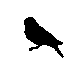

In [24]:
# Tokenize the dense_diffusion_prompt
text_input = pipe.tokenizer(dense_diffusion_prompt, padding="max_length", return_length=True, return_overflowing_tokens=False,
                            max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
cond_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

uncond_input = pipe.tokenizer([""] * bsz, padding="max_length", max_length=pipe.tokenizer.model_max_length,
                              truncation=True, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Ensure that wlen matches the length of widx
for i in range(1, len(dense_diffusion_prompt)):
    wlen = text_input['length'][i].item() - 2  # Convert tensor to int
    widx = text_input['input_ids'][i][1:1 + wlen]
    for j in range(77):
        if j + wlen <= 77 and (text_input['input_ids'][0][j:j + wlen] == widx).sum().item() == wlen:  # Use .item() to get the value
            break

# Process the layout image
layout_img_ = np.asarray(composite_image_rgb.resize([sp_sz * 8, sp_sz * 8]))[:, :, :3]
unique, counts = np.unique(np.reshape(layout_img_, (-1, 3)), axis=0, return_counts=True)
sorted_idx = np.argsort(-counts)

layouts_ = []

for i in range(len(dense_diffusion_prompt) - 1):
    if (unique[sorted_idx[i]] == [0, 0, 0]).all() or (unique[sorted_idx[i]] == [255, 255, 255]).all():
        layouts_ = [((layout_img_ == unique[sorted_idx[i]]).sum(-1) == 3).astype(np.uint8)] + layouts_
    else:
        layouts_.append(((layout_img_ == unique[sorted_idx[i]]).sum(-1) == 3).astype(np.uint8))

layouts = [torch.FloatTensor(l).unsqueeze(0).unsqueeze(0).cuda() for l in layouts_]
layouts = F.interpolate(torch.cat(layouts), (sp_sz, sp_sz), mode='nearest')

print('\n'.join(dense_diffusion_prompt))
Image.fromarray(np.concatenate([255 * _.squeeze().cpu().numpy() for _ in layouts], 1).astype(np.uint8))

# **Preparation for Spatial Regularization (sreg) and Cross-Attention Regularization (creg)**

In [25]:
###########################
###### prep for sreg ######
###########################
sreg_maps = {}
reg_sizes = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layouts_s = F.interpolate(layouts,(res, res),mode='nearest')
    layouts_s = (layouts_s.view(layouts_s.size(0),1,-1)*layouts_s.view(layouts_s.size(0),-1,1)).sum(0).unsqueeze(0).repeat(bsz,1,1)
    reg_sizes[np.power(res, 2)] = 1-1.*layouts_s.sum(-1, keepdim=True)/(np.power(res, 2))
    sreg_maps[np.power(res, 2)] = layouts_s


###########################
###### prep for creg ######
###########################
pww_maps = torch.zeros(1, 77, sp_sz, sp_sz).to(device)
for i in range(1,len(dense_diffusion_prompt)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if j + wlen <= 77 and (text_input['input_ids'][0][j:j + wlen].shape == widx.shape and (text_input['input_ids'][0][j:j + wlen] == widx).sum().item() == wlen):
            pww_maps[:,j:j+wlen,:,:] = layouts[i-1:i]
            cond_embeddings[0][j:j+wlen] = cond_embeddings[i][1:1+wlen]
            print(dense_diffusion_prompt[i], i, '-th segment is handled.')
            break

creg_maps = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layout_c = F.interpolate(pww_maps,(res,res),mode='nearest').view(1,77,-1).permute(0,2,1).repeat(bsz,1,1)
    creg_maps[np.power(res, 2)] = layout_c


###########################
#### prep for text_emb ####
###########################
text_cond = torch.cat([uncond_embeddings, cond_embeddings[:1].repeat(bsz,1,1)])

bird 1 -th segment is handled.


# **Latent Generation and Image Synthesis**

In [26]:
reg_part = .3
sreg = .3
creg = 1.

COUNT = 0

with torch.no_grad():
    latents = torch.randn(bsz,4,sp_sz,sp_sz, generator=torch.Generator().manual_seed(1)).to(device)
    image = pipe(dense_diffusion_prompt[:1]*bsz, latents=latents).images

  0%|          | 0/50 [00:00<?, ?it/s]

# **Dense Diffusion Image**

recusive_diff_prompt = A bird perched on a windowsill with a view of the city skyline.


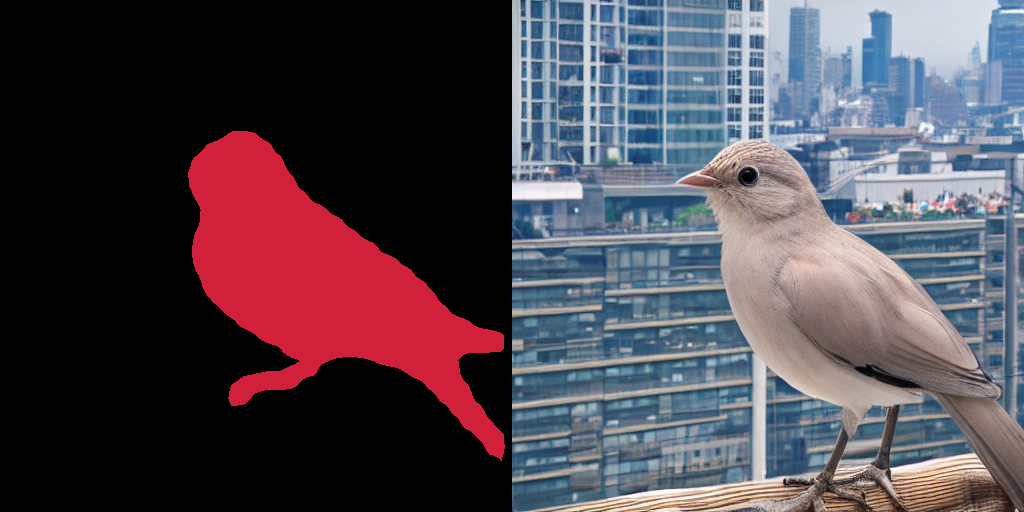

In [27]:
print("recusive_diff_prompt =",recusive_diff_prompt)
Image.fromarray(np.concatenate([layout_img_.astype(np.uint8)]+[np.asarray(image[i]) for i in range(len(image))], 1))

# **Simple Stable Diffusion Image**

Prompt = A bird perched on a windowsill with a view of the city skyline.


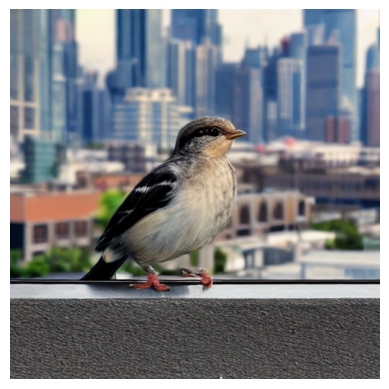

In [28]:
if gen_simple_stable_diff_image:
  print("Prompt =",recusive_diff_prompt)
  plt.imshow(stable_diffusion_image)
  plt.axis('off')
  plt.show()